In [1]:
import thesis_utils as tu
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
import seaborn as sns
from thesis_utils import data_prep
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.preprocessing import LabelEncoder

data = tu.Dataset()
td_df = data.translated_data
sd_df = data.site_data

In [11]:
m_df = pd.merge(td_df[['site_data_id', 'original_language']], sd_df[['id', 'category','origin']], left_on='site_data_id', right_on='id')
original = m_df[m_df['origin']=='original']
additional = m_df[m_df['origin']=='additional']

fdf = m_df.groupby('category').filter(lambda x: x['category'].value_counts() > 50)
print(fdf['category'].value_counts())


Food And Drink    217
Car                74
Groceries          65
Health             58
Travel             53
Name: category, dtype: int64


In [ ]:
X, y, vect = data_prep(data)
le = LabelEncoder()
y = le.fit_transform(y)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

models = [
    LinearSVC(),
    MLPClassifier(random_state=1, max_iter=500, hidden_layer_sizes=1000),
    SVC(kernel='precomputed'),
    GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0),
    LogisticRegression(random_state=0),
    MultinomialNB(),
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    if model_name == 'SVC':
        train_X_cosine = pairwise_kernels(train_X, metric='cosine')
        accuracies = cross_val_score(model, train_X_cosine, train_y, scoring='accuracy', cv=CV)
    else:
        accuracies = cross_val_score(model, train_X, train_y, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['Classifier', 'fold_idx', 'Accuracy'])
sns.boxplot(x='Classifier', y='Accuracy', data=cv_df)
# sns.stripplot(x='Classifier', y='Accuracy', data=cv_df, 
#         size=5, jitter=True, edgecolor="gray", linewidth=1)
# change sns x axis labels to be more readable
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('plot_explore_classifiers.pdf')

In [ ]:
print(cv_df.groupby('model_name').accuracy.mean())
# data_df = pd.merge(td_df[['site_data_id', 'original_language']], sd_df[['id', 'category', 'origin']], left_on='site_data_id', right_on='id')
# filtered_df.groupby('category').count()
# original['category'].value_counts()

In [ ]:
original = m_df[(m_df['origin'] == 'original') & (m_df['original_language'] == 'en')]
categories = m_df['category'].unique()

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 1
opacity = 0.5

df1_c = original['category'].value_counts()
# Add missing categories and fill with zeros
missing_categories = set(categories) - set(df1_c.index)
for category in missing_categories:
    df1_c = df1_c.append(pd.Series([0], index=[category]))
# Sort by category
df1_c = df1_c.sort_index()
category_labels = sorted(categories, key=lambda s: s.split()[0])
ax.bar(df1_c.index, df1_c.values, bar_width, alpha=opacity, color='b', label='Original Data')
ax.set_xlabel('Categories')
ax.set_ylabel('Count')
ax.set_xticks(np.arange(len(categories)))
ax.set_xticklabels(category_labels, rotation=90, fontsize=8)
ax.legend()
fig.tight_layout()
plt.show()
plt.close(fig)

# df1_c shows counts for the plot sum is 275

In [ ]:
# print(df1_c['category'].value_counts())
# print(df1_c['category'].value_counts().sum())
df1_c
df1_c.sum()

In [ ]:
# Clustermap of original data (interesting but maybe not super useful)

X, y, v = data_prep(data)
x = X.toarray()
df_tfidf = pd.DataFrame(x, columns=v.get_feature_names_out())
cm = sns.clustermap(x, cmap="vlag", center=0)
plt.xticks(rotation=90)
plt.xticks(range(len(df_tfidf.columns)), df_tfidf.columns, fontsize=4)
plt.show()


In [3]:
# coding=utf8
#!/usr/bin/env python3
import os
os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "2")  # Report only TF errors by default
import warnings
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

data = tu.Dataset()
texts, labels = tu.data_prep_fixed(data, origin_filter=None)
train_X, test_X, train_y, test_y = train_test_split(texts, labels, test_size=0.25, random_state=42, stratify=labels)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(train_X)
max_length = max(len(sequence) for sequence in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

label_encoder = {}
for i, label in enumerate(set(train_y)):
    label_encoder[label] = i
    
encoded_labels = np.array([label_encoder[label] for label in train_y])
num_classes = len(set(encoded_labels))
one_hot_labels = tf.keras.utils.to_categorical(encoded_labels, num_classes)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(word_index)+1, 32, input_length=max_length),
    tf.keras.layers.LSTM(64, dropout=0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(
            loss=tf.keras.losses.categorical_crossentropy, 
            optimizer=tf.keras.optimizers.Adam(jit_compile=False), 
            metrics=['accuracy'])
model.fit(padded_sequences, one_hot_labels, epochs=10, verbose=1)

new_sequences = tokenizer.texts_to_sequences(test_X)
new_padded_sequences = pad_sequences(new_sequences, maxlen=max_length, padding='post')
predictions = model.predict(new_padded_sequences)
accuracy = model.evaluate(new_padded_sequences, tf.keras.utils.to_categorical(np.array([label_encoder[label] for label in test_y]), num_classes))
print(accuracy)





Epoch 1/10
23/23 [==============================] - 7s 177ms/step - loss: 2.9884 - accuracy: 0.2427
Epoch 2/10
23/23 [==============================] - 4s 155ms/step - loss: 2.6664 - accuracy: 0.2734
Epoch 3/10
23/23 [==============================] - 3s 151ms/step - loss: 2.6367 - accuracy: 0.2734
Epoch 4/10
23/23 [==============================] - 3s 151ms/step - loss: 2.6330 - accuracy: 0.2734
Epoch 5/10
23/23 [==============================] - 3s 146ms/step - loss: 2.6339 - accuracy: 0.2734
Epoch 6/10
23/23 [==============================] - 3s 149ms/step - loss: 2.6336 - accuracy: 0.2734
Epoch 7/10
23/23 [==============================] - 3s 146ms/step - loss: 2.6334 - accuracy: 0.2734
Epoch 8/10
23/23 [==============================] - 3s 145ms/step - loss: 2.6305 - accuracy: 0.2734
Epoch 9/10
23/23 [==============================] - 3s 145ms/step - loss: 2.6304 - accuracy: 0.2734
Epoch 10/10
8/8 [==============================] - 1s 59ms/step - loss: 2.6204 - accuracy: 0.2750
[2

In [ ]:
# [2.6221745014190674, 0.2750000059604645] with fancy stop words


In [32]:
import nltk
from nltk.corpus import stopwords
from string import punctuation
from nltk.probability import FreqDist
from scipy.stats import fisher_exact

def preprocess_text(text):
    # tokenize the text
    tokens = nltk.word_tokenize(text)
    
    # remove stop words and punctuation
    stop_words = set(stopwords.words('english'))
    tokens = [word.lower() for word in tokens if word.lower() not in stop_words and word not in punctuation]
    return tokens


def create_freq_dist(tokens):
    freq_dist = FreqDist(tokens)
    return freq_dist

X, y = tu.data_prep_fixed(data, origin_filter=None)
# create a dataframe of the text data and the labels
fisher_df = pd.DataFrame({'text': X, 'label': y})
grouped = fisher_df.groupby('label')

freq_dists = {}
for label, group in grouped:
    freq_dists[label] = {}
    for text in group['text']:
        tokens = preprocess_text(text)
        freq_dist = create_freq_dist(tokens)
        for token, freq in freq_dist.items():
            if token not in freq_dists[label]:
                freq_dists[label][token] = 0
            freq_dists[label][token] += freq

categories = list(freq_dists.keys())

contingency_tables = {}
for keyword in freq_dists[categories[0]]:
    contingency_table = []
    for category in categories:
        freq = freq_dists[category][keyword] if keyword in freq_dists[category] else 0
        nonfreq = sum(freq_dists[category].values()) - freq
        contingency_table.append([freq, nonfreq])
    contingency_tables[keyword] = contingency_table

p_values = {}
for keyword, contingency_table in contingency_tables.items():
    odds_ratio, p_value = fisher_exact(contingency_table)
    p_values[keyword] = p_value

sorted_keywords = sorted(p_values.items(), key=lambda x: x[1])


ValueError: The input `table` must be of shape (2, 2).

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
import thesis_utils as tu
# Load some text data
data = tu.Dataset()
X, y = tu.data_prep_fixed(data, origin_filter=None)
print(X[0])
# Create TfidfVectorizer with stop words removed
v = TfidfVectorizer(stop_words='english')

# Fit and transform the text data using the vectorizer
X_train = v.fit_transform(X)
# transfomr x back into text 
print(v.inverse_transform(X_train[0]))
# join the text back together
print(' '.join(v.inverse_transform(X_train[0])[0]))


Veski tavern for bread and fun Veski tavern for bread and fun Move to the contents Home Bread Lust Album Veski Kodu Veski Tavern is like a summer milkshake in the middle of Tondi settlement It's fun to have breakfast behind long farm tables
[array(['tables', 'farm', 'long', 'breakfast', 'settlement', 'tondi',
       'middle', 'milkshake', 'summer', 'like', 'kodu', 'album', 'lust',
       'home', 'contents', 'fun', 'bread', 'tavern', 'veski'],
      dtype='<U81')]
tables farm long breakfast settlement tondi middle milkshake summer like kodu album lust home contents fun bread tavern veski


In [3]:
import pandas as pd
data = tu.Dataset()
X, y = tu.data_prep_fixed(data, origin_filter=None)
# join X and y into a dataframe
df = pd.DataFrame({'text': X, 'label': y})
# show all text with label consumer goods
res = df[df['label'] == 'Investments']['text'].values

for i, r in enumerate(res):
    print(i, r[:50])


0 Patria Finance Search Login CS SK EN Why Patria Fi
1 Home TESLA investiční společnost
2 Sirius investment company Please wait Investment a
3 Pravda Capital Investment for those who strive to 
4 Summit Financial Group Investments Financial Plann
5 Advisor Financial Services of America FSA Warren t
6 Home Financial Solutions of Michigan fsmfinancial 


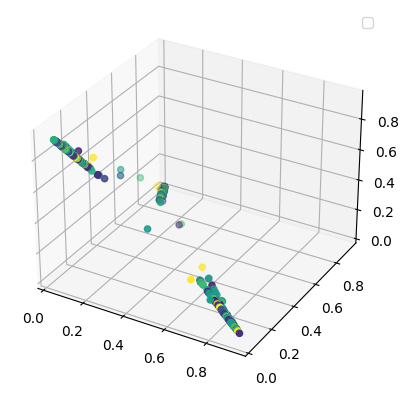

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import thesis_utils as tu
from tensorflow.keras.datasets import mnist
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, LatentDirichletAllocation


# Load MNIST dataset
# (X_train, y_train), (X_test, y_test) = mnist.load_data()
data = tu.Dataset()
texts, labels = tu.data_prep_fixed(data, origin_filter=None)
le = LabelEncoder()
labels = le.fit_transform(labels)
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.25, random_state=42, stratify=labels)

vectorizer = tu.tfidf_vectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Reshape images to 1D array
X_train = X_train.reshape((X_train.shape[0], -1))

# Reduce dimensionality with t-SNE
# X_embedded = TSNE(n_components=3, verbose=1).fit_transform(X_train)

# Reduce dimensionality with PCA
# X_train = X_train.toarray()
# X_embedded = PCA(n_components=3).fit_transform(X_train)

# Reduce dimensionality with LDA
lda = LatentDirichletAllocation(n_components=3, random_state=0)
X_embedded = lda.fit_transform(X_train)


# Plot data in 3D
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], c=y_train)
# add legend
ax.legend()
plt.show()
